In [1]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )


using device: cuda


In [3]:
import torch
from sam2.sam2_video_predictor import SAM2VideoPredictor

predictor = SAM2VideoPredictor.from_pretrained("facebook/sam2-hiera-large", device=device)

In [4]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_img = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_img)

def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

In [5]:
import pandas as pd
import numpy as np

file_info_df = pd.read_csv('dataset/EchoNet/FileInfo.csv')
points_df = pd.read_csv('dataset/EchoNet/Points.csv')

file_info_df

,FileName,Split,ESV,EDV
0,0X650881B7ADEF9668,Train,179,157
1,0X23B1641319A2AFA2,Train,66,50
2,0X21780197024E9D79,Train,76,61
3,0X304FEB38430F6379,Train,63,46
4,0X7FE48E5475ADE2E3,Train,94,119
...,...,...,...,...
10025,0X234005774F4CB5CD,Test,-1,-1
10026,0X2DC68261CBCC04AE,Test,-1,-1
10027,0X35291BE9AB90FB89,Test,-1,-1
10028,0X6C435C1B417FDE8A,Test,-1,-1


In [6]:
data_names = file_info_df[file_info_df['Split'] == 'Train']['FileName'].values
data_names


array(['0X650881B7ADEF9668', '0X23B1641319A2AFA2', '0X21780197024E9D79',
       ..., '0X60AC441DE6762A5C', '0X2989EFBB544B63BF',
       '0X36AE471FEC81D0F8'], dtype=object)

0X2D597332A98E785E 91


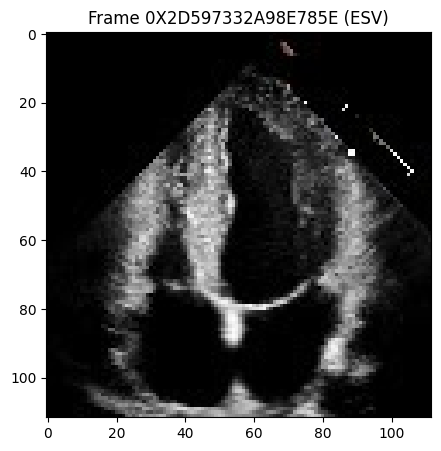

In [7]:
frame = data_names[242]
video_dir = f'dataset/EchoNet/Images/{frame}'
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda x: int(os.path.splitext(x)[0]))

esv_idx = file_info_df[file_info_df['FileName'] == frame]['ESV'].values[0]
print(frame, esv_idx)
plt.figure(figsize=(5, 5))
plt.title(f"Frame {frame} (ESV)")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[esv_idx])))

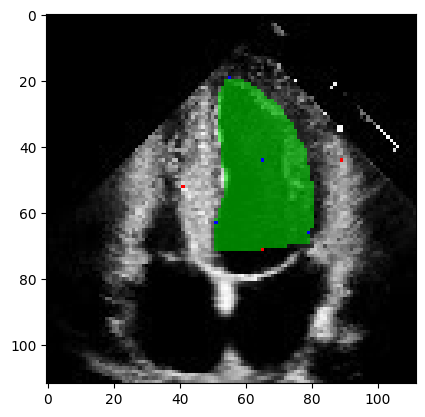

In [10]:
import cv2
from PIL import Image, ImageDraw

train_df = file_info_df[file_info_df['Split'] == 'Train']
tracings_df = pd.read_csv('dataset/EchoNet/VolumeTracings.csv')

def cycling_points(name, frame):
    tracings = tracings_df[tracings_df['FileName'] == name]
    frames = tracings['Frame'].unique()
    t = tracings[tracings['Frame'] == frame]
    points_l = list()
    points_r = list()
    for i in range(len(t)):
        c_1 = min(int(t.iloc[i]['X1'] + 0.5), 111)
        r_1 = min(int(t.iloc[i]['Y1'] + 0.5), 111)
        c_2 = min(int(t.iloc[i]['X2'] + 0.5), 111)
        r_2 = min(int(t.iloc[i]['Y2'] + 0.5), 111)
        if c_1 > c_2:
            c_1, c_2 = c_2, c_1
            r_1, r_2 = r_2, r_1
        points_l.append((c_1, r_1))
        points_r.append((c_2, r_2))
    points_l.sort(key=lambda x: x[1])
    points_r.sort(key=lambda x: x[1], reverse=True)
    points = points_l + points_r
    return points

name = frame
esv_frame = train_df[train_df['FileName'] == name]['ESV'].values[0]
img_path = f'dataset/EchoNet/Images/{name}/{esv_frame}.jpg'
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
poly_img = Image.new('RGBA', img.shape, (0,0,0,0))
draw = ImageDraw.Draw(poly_img)
polygon_coords = cycling_points(f'{name}.avi', esv_frame)
polygon_coords
draw.polygon(polygon_coords, fill=(0, 255, 0, 128))

all_points = points_df[points_df['FileName'] == name]
positive_points = [(min((int(all_points['PositiveTopX'].values[0]+0.5)), 111), min(int(all_points['PositiveTopY'].values[0]+0.5), 111)), 
                (all_points['PositiveCenterX'].values[0], all_points['PositiveCenterY'].values[0]), 
                (all_points['PositiveLeftX'].values[0], all_points['PositiveLeftY'].values[0]), 
                (all_points['PositiveRightX'].values[0], all_points['PositiveRightY'].values[0])]
negative_points = [(min(int(all_points['NegativeBottomX'].values[0]+0.5), 111), min(int(all_points['NegativeBottomY'].values[0]+0.5), 111)), 
                (all_points['NegativeLeftX'].values[0], all_points['NegativeLeftY'].values[0]), 
                (all_points['NegativeRightX'].values[0], all_points['NegativeRightY'].values[0])]
draw.point(positive_points, fill=(0, 0, 255))
draw.point(negative_points, fill=(255, 0, 0))
fig, ax = plt.subplots()
ax.imshow(img, cmap='gray')
ax.imshow(poly_img)
plt.show()

In [11]:
inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG): 100%|██████████| 296/296 [00:05<00:00, 58.40it/s]
/home/behan/micromamba/envs/DeepEcho/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  return F.conv2d(input, weight, bias, self.stride,


In [12]:
predictor.reset_state(inference_state)

/home/behan/micromamba/envs/DeepEcho/lib/python3.10/site-packages/sam2/sam2_video_predictor.py:873: UserWarning: cannot import name '_C' from 'sam2' (/home/behan/micromamba/envs/DeepEcho/lib/python3.10/site-packages/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/segment-anything-2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(


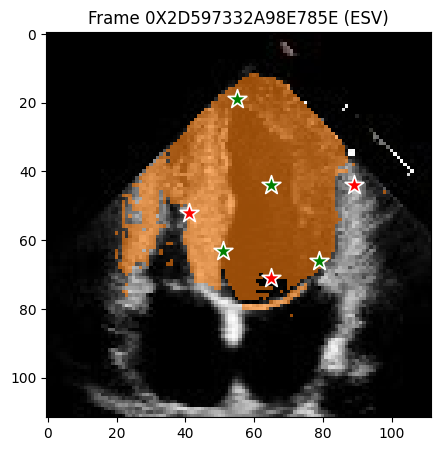

In [13]:
ann_frame_idx = esv_idx
ann_obj_id = 1
frame_points = points_df[points_df['FileName'] == frame]
# frame_points['PositiveTopX'].values[0]
pos_points = np.array(
    [
        [frame_points['PositiveTopX'].values[0], frame_points['PositiveTopY'].values[0]],
        [frame_points['PositiveLeftX'].values[0], frame_points['PositiveLeftY'].values[0]],
        [frame_points['PositiveRightX'].values[0], frame_points['PositiveRightY'].values[0]],
        [frame_points['PositiveCenterX'].values[0], frame_points['PositiveCenterY'].values[0]],
        [frame_points['NegativeBottomX'].values[0], frame_points['NegativeBottomY'].values[0]],
        [frame_points['NegativeLeftX'].values[0], frame_points['NegativeLeftY'].values[0]],
        [frame_points['NegativeRightX'].values[0], frame_points['NegativeRightY'].values[0]],
    ],
    dtype=np.float32)
labels = np.array([1, 1, 1, 1, 0, 0, 0], dtype=np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=pos_points,
    labels=labels,
)

plt.figure(figsize=(5, 5))
plt.title(f"Frame {frame} (ESV)")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[esv_idx])))
show_points(pos_points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

propagate in video: 100%|██████████| 205/205 [00:18<00:00, 11.05it/s]
/tmp/ipykernel_30580/2747821646.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(5, 5))


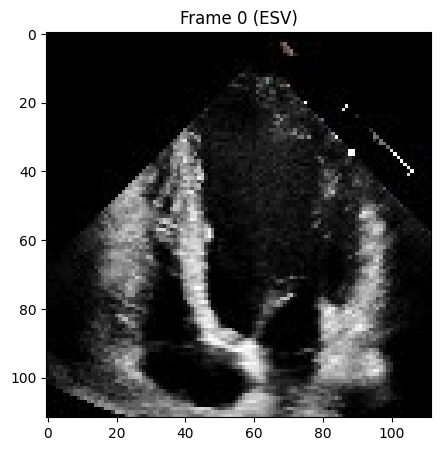

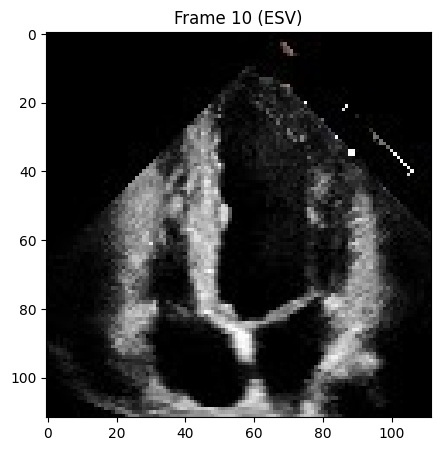

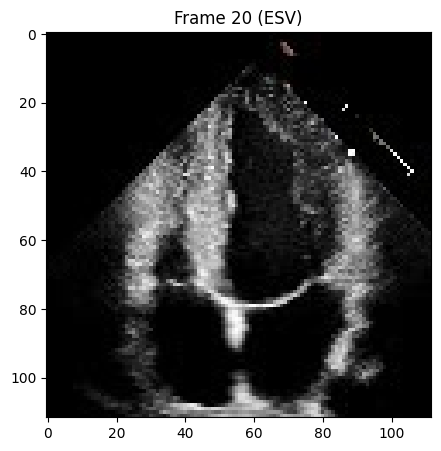

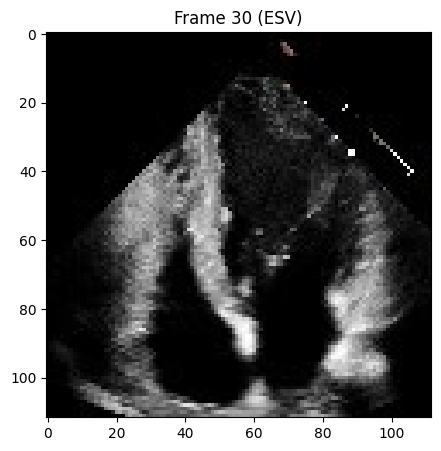

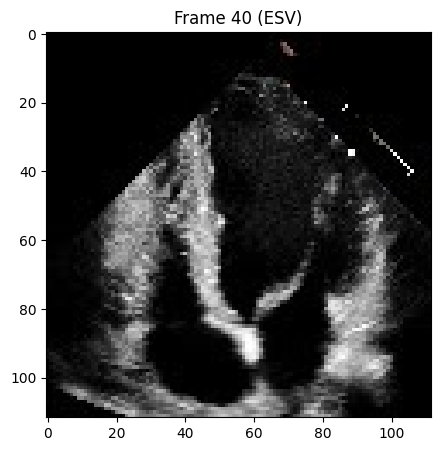

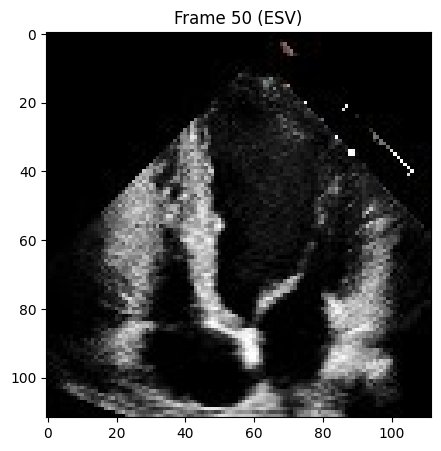

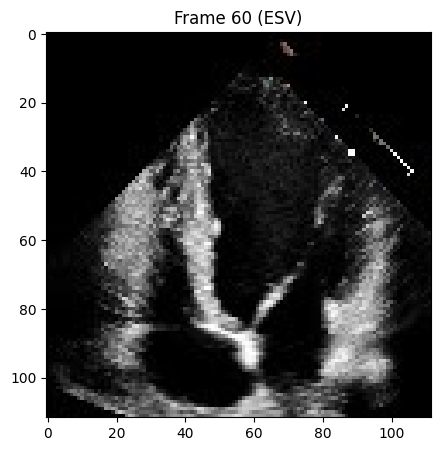

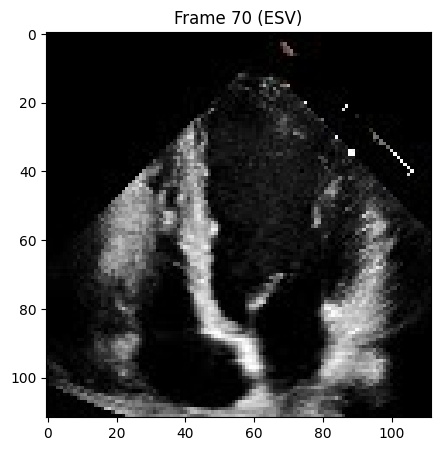

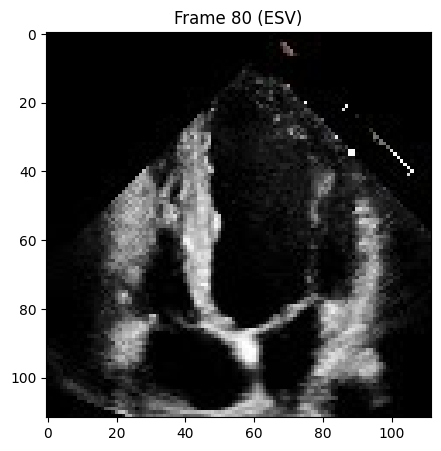

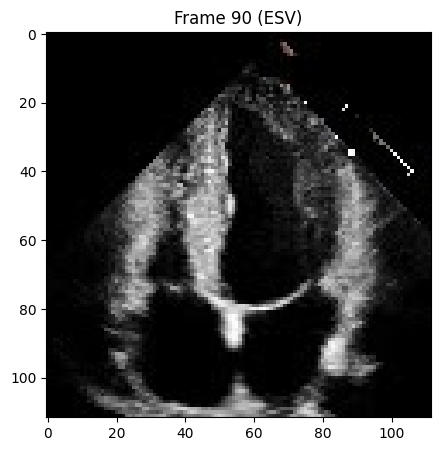

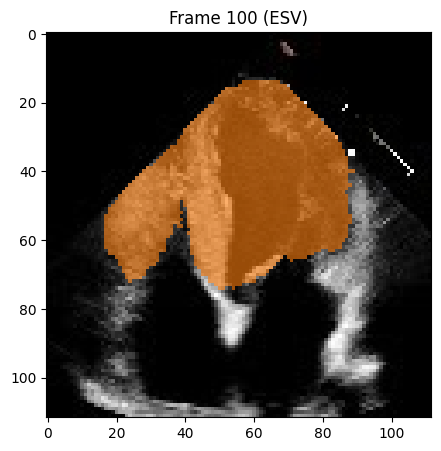

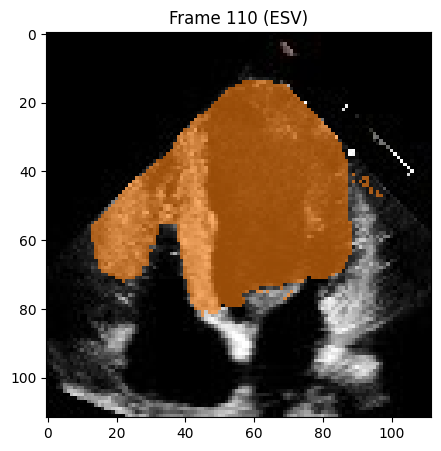

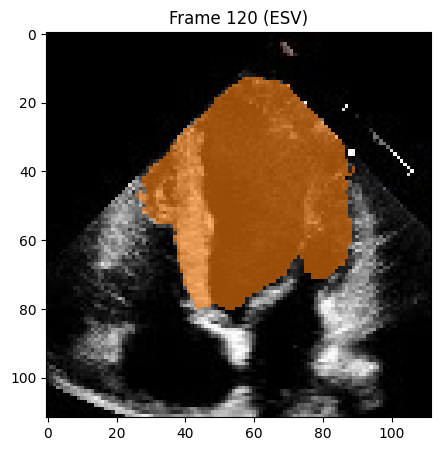

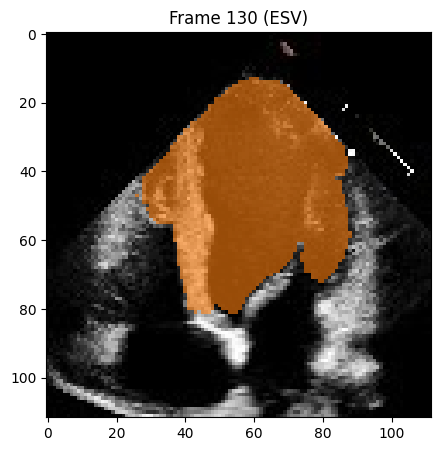

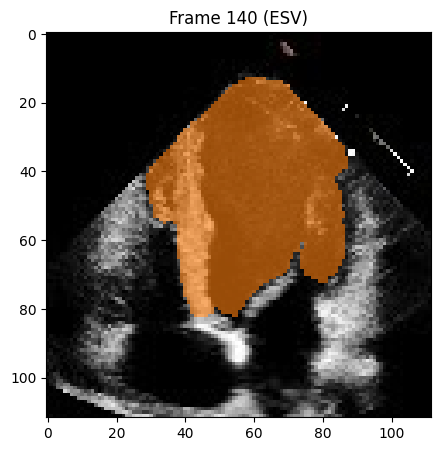

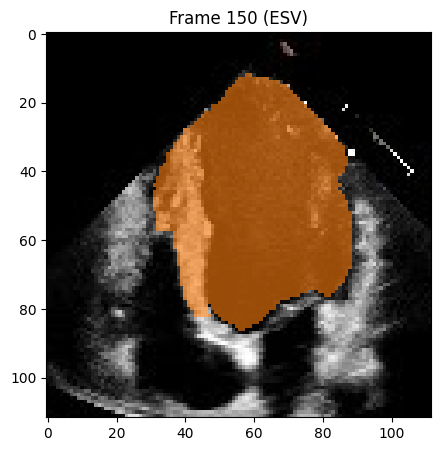

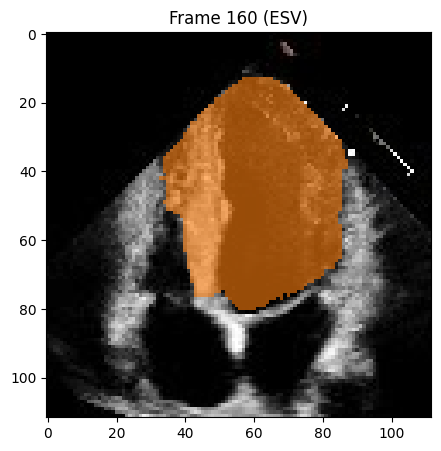

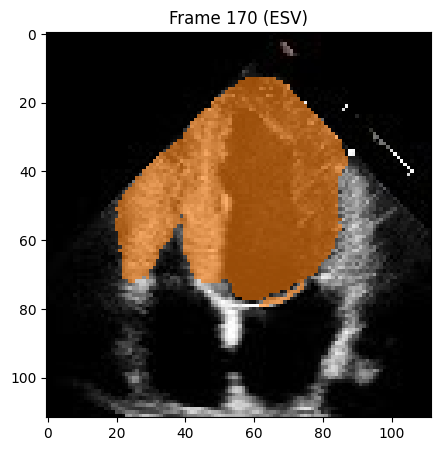

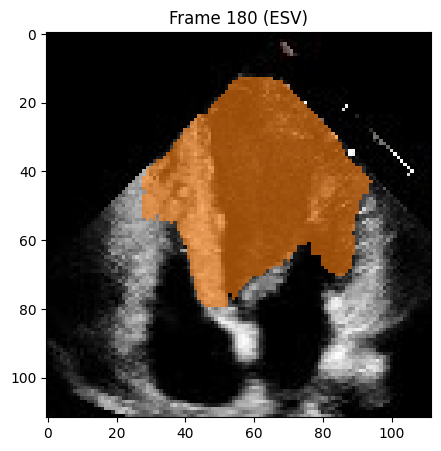

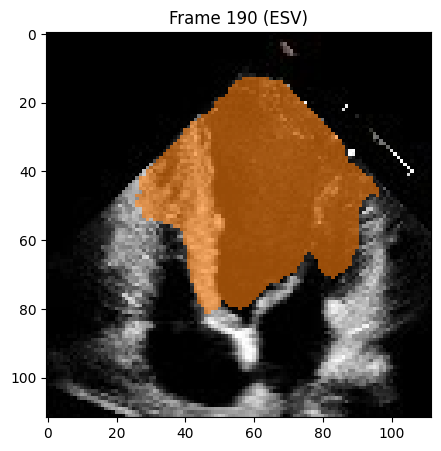

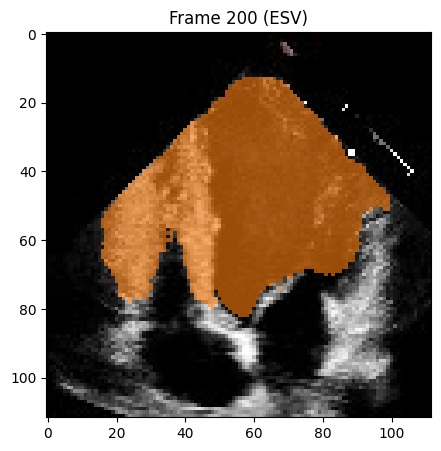

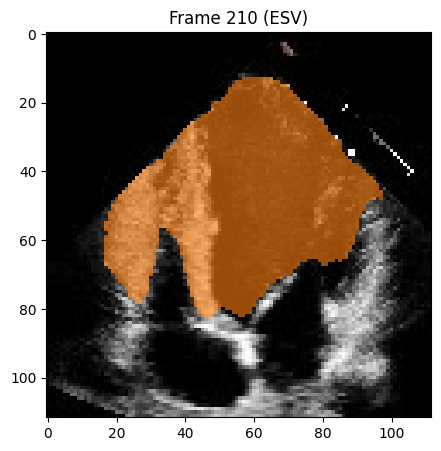

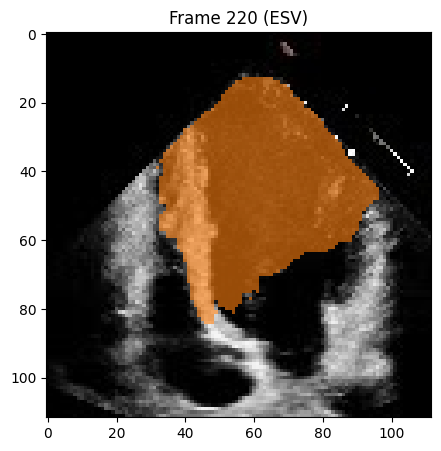

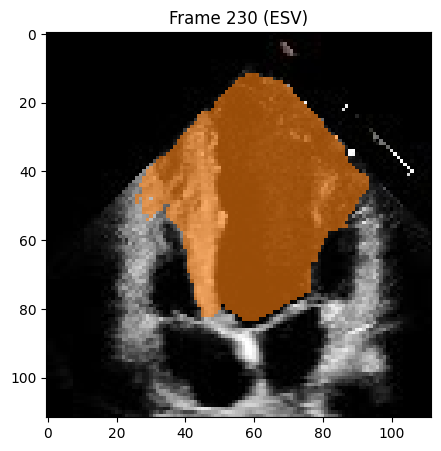

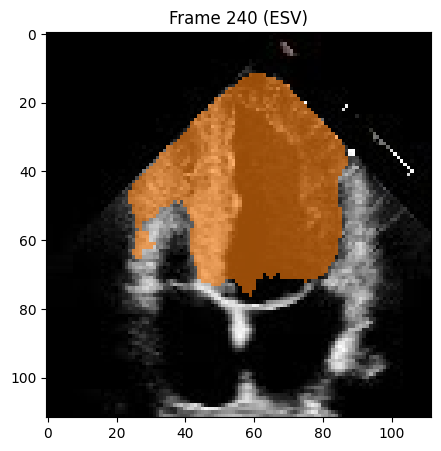

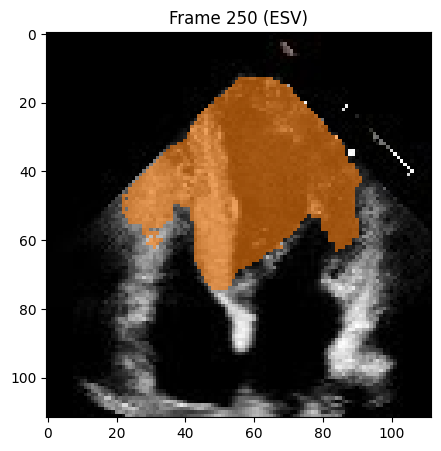

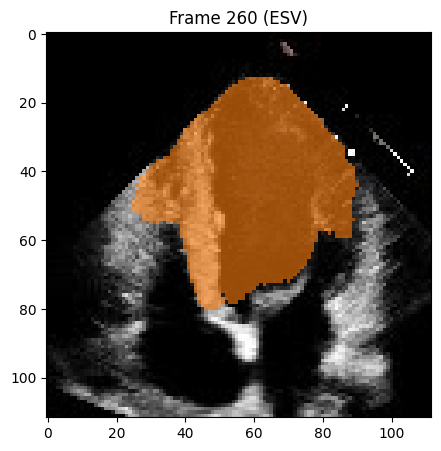

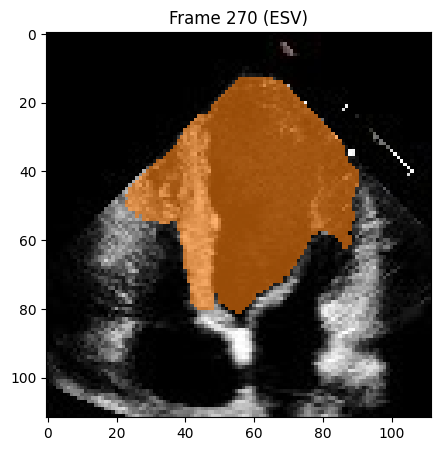

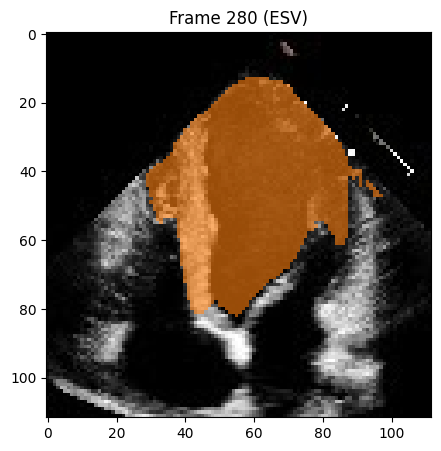

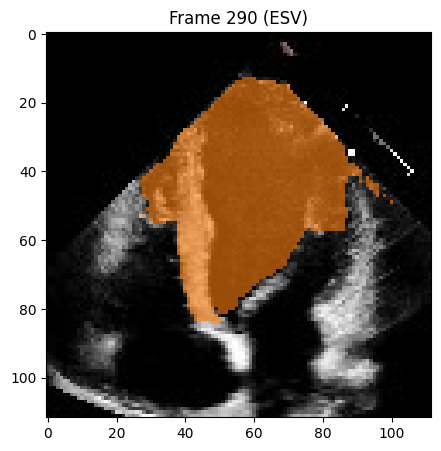

In [14]:
video_segments = {}
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }
    
vis_frame_stride = 10
plt.close('all')
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(5, 5))
    plt.title(f"Frame {out_frame_idx} (ESV)")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    if out_frame_idx in video_segments:
        for out_obj_id, out_mask in video_segments[out_frame_idx].items():
            show_mask(out_mask, plt.gca(), obj_id=out_obj_id)
